In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.scale import FuncScale

In [5]:
heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen']

path_data = './data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.
cols = [1,2,3,4,9,13,14,15,16,17,25,27]


In [6]:
def extractor(cluster, path_data=path_data):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data) #check what your pc does here
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + dyn + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heade)#, names=heade)
        #dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        #dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
        data = data[data['t_elapsed'] != 136000]
    return data

In [30]:
def rndmfrst(cluster, listwhattodrop, target, title, n_estimators=50, max_depth=20, random_state=42, n_jobs=6, cv=5):
    dataysc = extractor(cluster)
    #dataysc['DiffSpin'] = abs(dataysc.S2 - dataysc.S1)
    df = dataysc.drop(columns=listwhattodrop)
    del dataysc

    feature_names = list(df.columns)
    feature_names.remove(target)

    X = df.drop(columns=target)
    y = df[target]

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', model)])

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
        'rmse': make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))  # RMSE
    }

    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, return_estimator=True)

    # Compute mean and std for each metric
    print(f"Cross-Validation ({cv}-fold) Results:")
    print(f"R² Score: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
    print(f"MAE: {cv_results['test_mae'].mean():.4f} ± {cv_results['test_mae'].std():.4f}")
    print(f"MSE: {cv_results['test_mse'].mean():.4f} ± {cv_results['test_mse'].std():.4f}")
    print(f"RMSE: {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")

    best_estimator = cv_results['estimator'][np.argmax(cv_results['test_r2'])]  # Choose model with highest R²
    feature_importances = best_estimator.named_steps['regressor'].feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.grid(True, axis='y', linestyle="--", linewidth=0.6)
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance Score")
    plt.yscale('log')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return print(f'Feature importances: {feature_importances[sorted_idx]}')


##################### Graphs ################
def hist2dgraph( x,y, nxbin,nybin, title, axx, axy, vmin, vmax, scale='linear'):
    if scale == 'linear':
        xbin= np.linspace(x.min(),x.max(),nxbin)
        ybin= np.linspace(y.min(),y.max(),nybin)
        plt.xscale('linear')
        plt.yscale('linear')
    elif scale == 'log':
        xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)
        ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
        plt.xscale('log')
        plt.yscale('log')
    hist = plt.hist2d(x,y,bins=(xbin,ybin), cmap="Blues", norm=colors.LogNorm( vmin=vmin, vmax=vmax))
    plt.title(title)
    plt.xlabel(axx)
    plt.ylabel(axy)
    return hist

In [24]:
data = extractor('nsc')

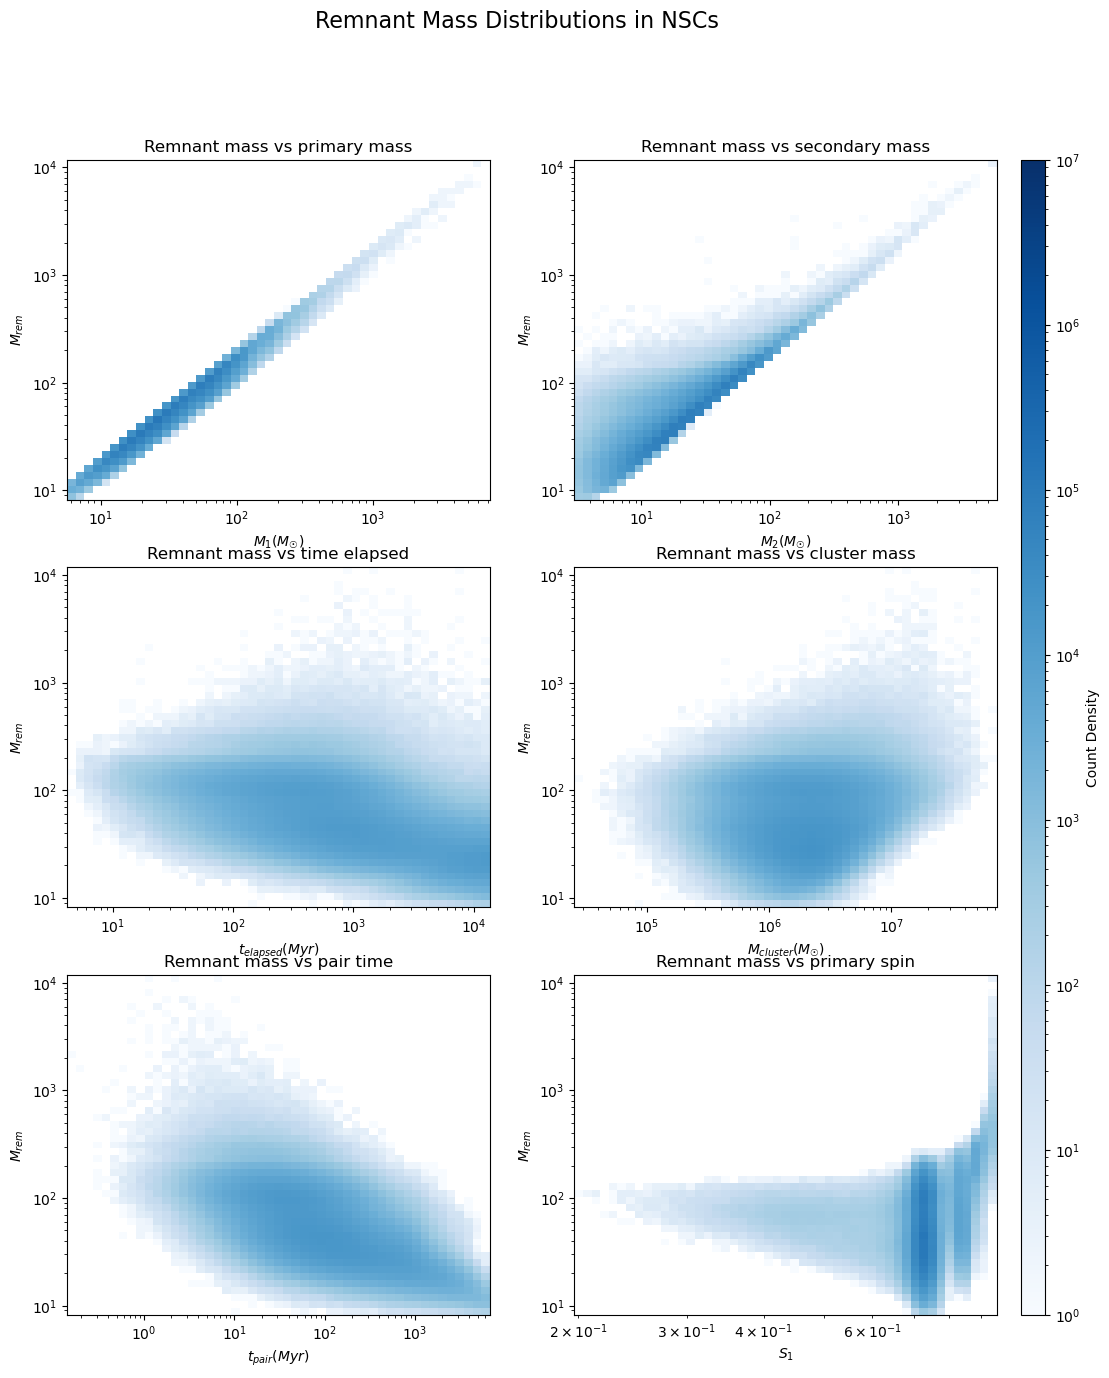

In [33]:
#data = dat
#data = data[data.M1<2000]

fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in NSCs", fontsize=16)
plt.sca(ax[0,0])
hist = hist2dgraph(data.M1,data.Mrem,50,50,'Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[0,1])

hist2 = hist2dgraph(data.M2,data.Mrem,50,50,'Remnant mass vs secondary mass',u'$M_2 (M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[1,0])
hist = hist2dgraph(data.t_elapsed,data.Mrem,50,50,'Remnant mass vs time elapsed',u'$t_{elapsed} (Myr)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[1,1])
jist3 = hist2dgraph(data.Mcluster,data.Mrem,50,50,'Remnant mass vs cluster mass',u'$M_{cluster}(M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[2,0])
hist2 = hist2dgraph(data.t_pair,data.Mrem,50,50,'Remnant mass vs pair time',u'$t_{pair}(Myr)$', u'$M_{rem}$', 1, 1e7, 'log')
#plt.xticks([1,2,3,4,5,6,7])

plt.sca(ax[2,1])
hist2 = hist2dgraph(data.S1,data.Mrem,50,50,'Remnant mass vs primary spin',u'$S_1$', u'$M_{rem}$', 1, 1e7, 'log')


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
